In [1]:
from autolens.data.imaging import image as im
from autolens.data.array import mask as ma
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lensing import ray_tracing
from autolens.lensing import lensing_image as li
from autolens.lensing import lensing_fitting
from autolens.model.inversion import pixelizations as pix, regularization as reg
from autolens.data.imaging.plotters import imaging_plotters
from autolens.lensing.plotters import ray_tracing_plotters
from autolens.model.inversion.plotters import inversion_plotters, mapper_plotters

# Up to now, all our mappers have had their border input as 'None', and you may be wondering what inputting a border
# actually does. Well, it turns out borders are pretty important, and they are what we'll be covering in this tutorial.

In [2]:
# To begin, lets simulate a simple image and use it to generate a rectangular mapper, as we're now used to doing.
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing
    
    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = grids.DataGrids.grids_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                        einstein_radius=1.6))
    source_galaxy_0 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=90.0, intensity=0.2,
                                                         effective_radius=0.3, sersic_index=1.0))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy],
                                                 source_galaxies=[source_galaxy_0],
                                                 image_plane_grids=[image_plane_grids])

    return im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

In [3]:
# Lets have a quick look at the image.
image = simulate()
imaging_plotters.plot_image_subplot(image=image)

NoSectionError: No section: 'output'

In [9]:
# So, what is a border? In the image-plane, a border is the set of exterior pixels in a mask that are at, well, its
# border. Lets plot the image with a circular mask, and tell our imaging plotter to plot the border as well.
mask_circular = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=2.5)
imaging_plotters.plot_image_subplot(image=image, mask=mask_circular, should_plot_border=True)

NoSectionError: No section: 'output'

In [11]:
# As you can see, for a circular mask, the border *is* the edge of our mask (the ring of black dots we're used to seeing
# whenever we plot a mask). For an annular mask, not every pixel on the edge of the mask is necessarily a part of its
# border!
mask_annular = ma.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale, inner_radius_arcsec=0.8,
                       outer_radius_arcsec=2.5)
imaging_plotters.plot_image_subplot(image=image, mask=mask_annular, should_plot_border=True)

# Indeed, a border is *only* the pixels at the exterior edge of our mask, which for the annular mask above means non of 
# the pixels at the inner radius = 0.8" edge are part of the border.

NoSectionError: No section: 'output'

In [12]:
# So, what does a border actually do? To show you, we'll need to fit this image with a lens model and mapper, and we'll
# do that by using the same function as the previous tutorial (to perform a quick source galaxy fit) but with the
# option to input a mask and use a border.
def perform_fit_with_source_galaxy_mask_and_border(source_galaxy, mask, use_border):

    image = simulate()
    lensing_image = li.LensingImage(image=image, mask=mask)
    lens_galaxy = g.Galaxy(
        mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6))

    if use_border:
        border = lensing_image.border
    else:
        border = None

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[lensing_image.grids], border=border)
    return lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)

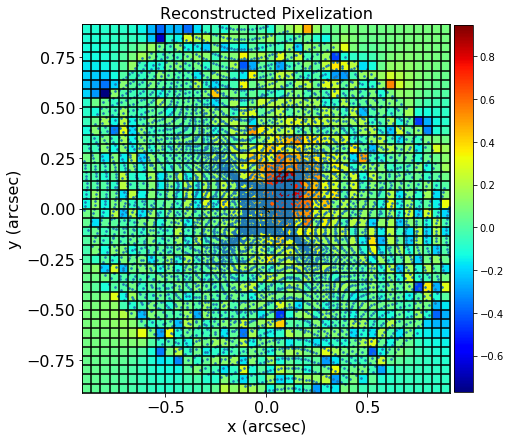

In [13]:
# Okay, so lets first look at our mapper without using a border, and using our annular mask.
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(1.0,)))
fit = perform_fit_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_annular, use_border=False)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True)

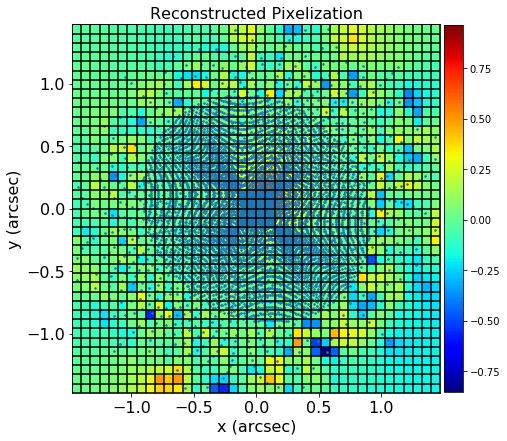

In [14]:
# Everything looks fine - we get a reconstructed source on a visually appeasing source-plane grid. So, why are we
# so worried about borders? Lets see what happens if we use a circular mask instead.
fit = perform_fit_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular, use_border=False)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True)

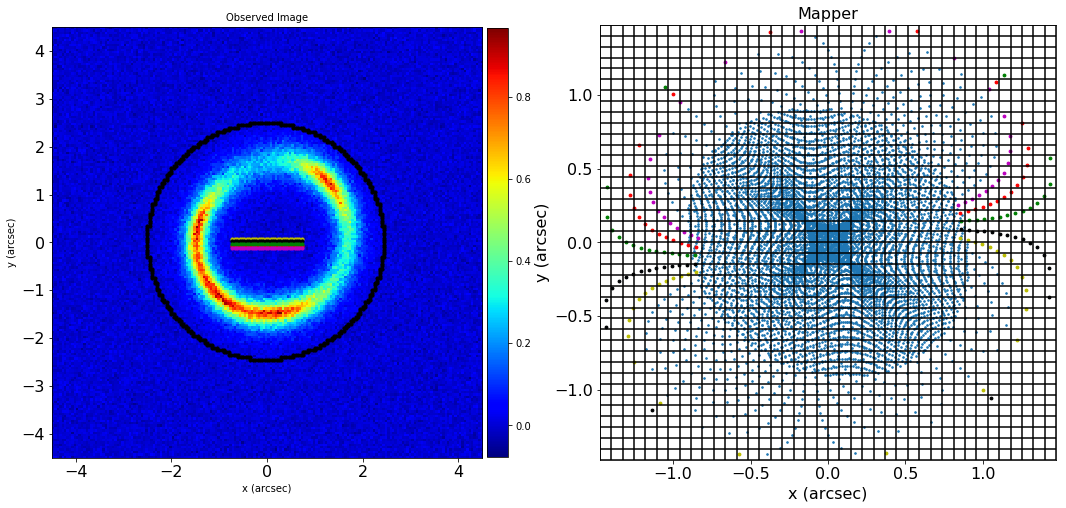

In [15]:
# Woah - whats happened? There are lots of extra points on our source-plane grid, which trace to extremely large radii
# away from the central regions of the source-plane! These points are traced image-pixels (just like all the other
# points) which correspond to the central image-pixels that our annular mask masked, but that our circular mask didn't!

# Lets quickly check this using a mapper plotter
mapper_plotters.plot_image_and_mapper(image=image, mapper=fit.mapper, mask=mask_circular, should_plot_grid=True,
                                      image_pixels=[[range(3765, 3795)], [range(4065, 4095)], [range(3865, 3895)],
                                                    [range(3965, 3995)], [range(4165, 4195)]])

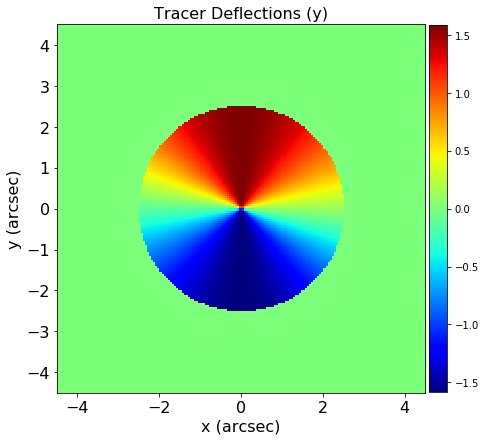

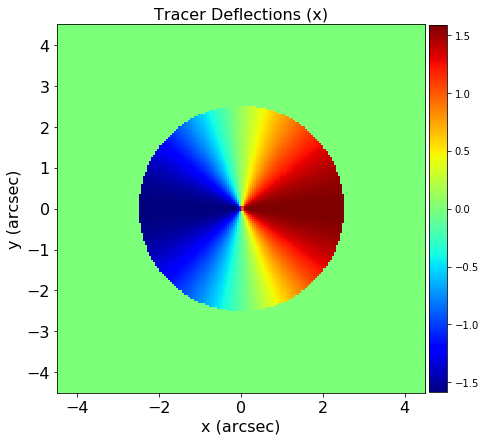

In [16]:
# So, whats happening physically? Towards the centre of our EllipticalIsothermal mass profile (and in general most
# other mass profiles), the density profile becomes extremely cuspy (it begins to rise very sharly). This cause
# extremely large deflection angles to be computed - lets have a quick look.
ray_tracing_plotters.plot_deflections_y(tracer=fit.tracer)
ray_tracing_plotters.plot_deflections_x(tracer=fit.tracer)

In [18]:
# This means that our central image pixels are highly demagnified - they trace to extremely large values in the source
# plane! Physically, this isn't a problem - it just means that we don't see a 'central image' in most strong lenses,
# as the light-rays through the centre of the lens are demagnified (although if the lens galaxy had a flat, cored mass
# distribution we would see this central image, and it has been observed in a real strong lens!)

# However, it is a problem for our pixelization and mapper, which in the source-plane fits these demagnified pixels
# like all of the other pixels. This has two devasting consequences:

# 1) The rectangular grid we 'overlay' over the source-plane is much larger than for the annular mask, because it has to
#    expand to also include all of the demagnified traced image-pixels. As a result, large source-pixels are used to
#    reconstruct the central regions of the source-plane (where the source galaxy is actually located), meaning we
#    reconstruct the source-galaxy at a lower effective resolution.

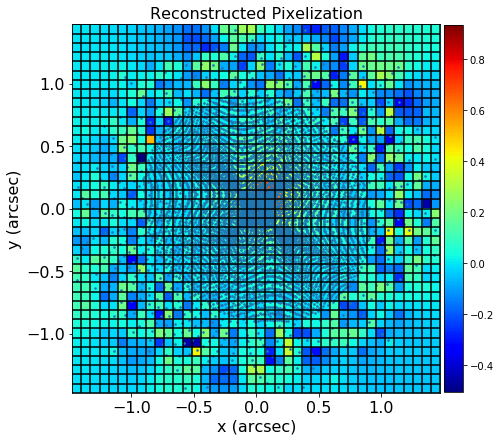

In [19]:
# 2) The rectangular grid reconstructs the flux of the demanigified image pixels, using source-pixels which contain
#    *only* demagnified image pixels. However, these source-pixels *should* have other traced image-pixels in
#    them, coming from pixels at large radii from the centre of the lens galaxy. Unfortunately, our circular mask
#    masks them out, meaning they never make it to our source-plane and are omitted from the source reconstruction. 
#    Lets quickly use a larger circular mask to confirm that these pixels do exist, if we don't mask them.
mask_circular_large = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=4.0)
fit = perform_fit_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular, use_border=False)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True)

In [20]:
#   This second point is a *huge* problem, as allowing source-pixels to fit regions of our mask in this completely 
#   unphysical way introduces extremely dangerous systematics into our source reconstruction and lens model analysis. 
#   You can see this in the weird patterns these pixels make in the exterior regions of our source-reconstruction!

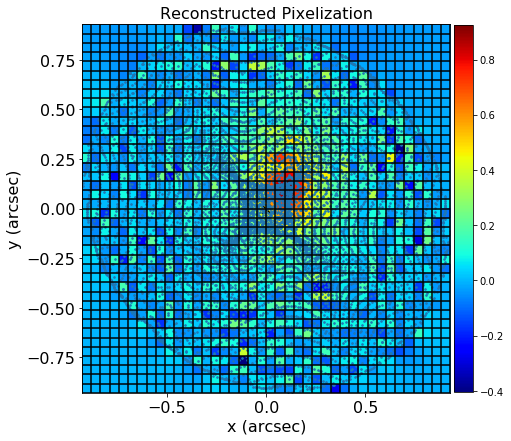

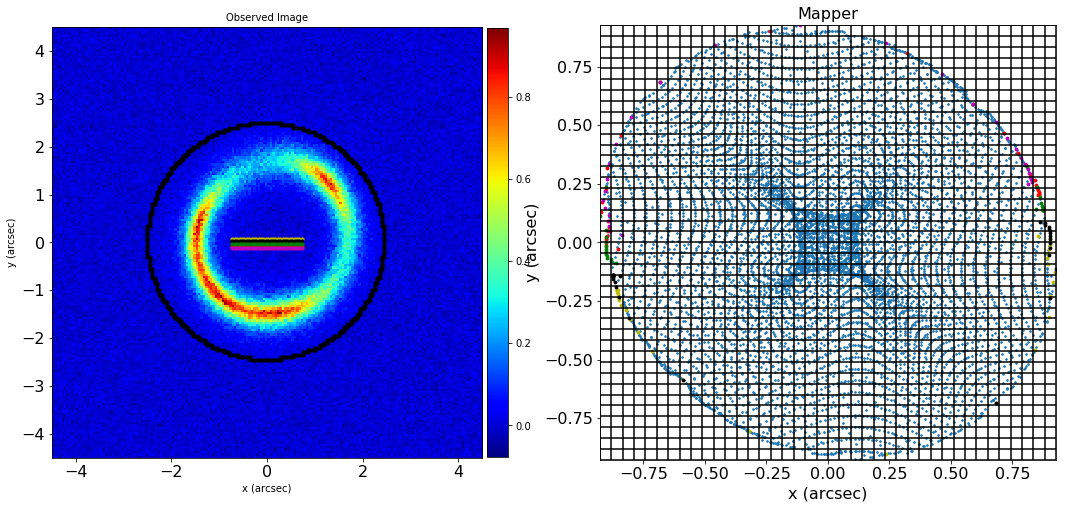

In [21]:
# Borders are the solution to this problem. All we do, is we take the mask border in the image-plane we showed above,
# trace it to the source-plane, and relocate all traced image-pixels pixels outside this source-plane border to its
# edge. Lets take a look.
fit = perform_fit_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular, use_border=True)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True)
mapper_plotters.plot_image_and_mapper(image=image, mapper=fit.mapper, mask=mask_circular, should_plot_grid=True,
                                      image_pixels=[[range(3765, 3795)], [range(4065, 4095)], [range(3865, 3895)],
                                                    [range(3965, 3995)], [range(4165, 4195)]])

In [22]:
# This successfully addresses both of the issues above! However, you might be thinking, isn't that a bit of a hack? Its
# not really a physical treatment of the ray-tracing, is it?

# Well, you're right, its certainly not the most physical way to tackle this problem. However, the *only* physical
# way to do this would be to use a mask so large that all demangified central pixels are surrounded by traced
# image-pixels. This would requires masks so large our computers would crash, because they run out of memory. That's not 
# a good solution, thus borders provide us with a workaround - one that I've extensively tested and have found that, 
# provided your mask isn't too small, doesn't lead to systematic biases.

In [24]:
# Next, I'm going to quickly highlight how important borders are when modeling multiple lens galaxies. Their complex
# mass distribution and lensing configuration often produce very nasty edge effects, whereby image pixels not in the
# centre of mask, but anywhere in the mask, trace beyond the source-plane border.
def simulate_image_x2_lenses():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = grids.DataGrids.grids_for_simulation(shape=(300, 300), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy_0 = g.Galaxy(
        mass=mp.EllipticalIsothermal(centre=(1.1, 0.51), axis_ratio=0.9, phi=110.0, einstein_radius=1.07))
    lens_galaxy_1 = g.Galaxy(
        mass=mp.EllipticalIsothermal(centre=(-0.20, -0.35), axis_ratio=0.56, phi=16.0, einstein_radius=0.71))
    source_galaxy_0 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.05, 0.05), axis_ratio=0.8, phi=90.0, intensity=0.2,
                                                         effective_radius=0.3, sersic_index=1.0))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy_0, lens_galaxy_1],
                                                 source_galaxies=[source_galaxy_0],
                                                 image_plane_grids=[image_plane_grids])

    return im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

In [25]:
# Lets simulate our 2 lens system, define a new circular mask and plot them.
image = simulate_image_x2_lenses()
mask_circular = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=2.8)
imaging_plotters.plot_image_subplot(image=image, mask=mask_circular, should_plot_border=True)


NoSectionError: No section: 'output'

In [27]:
# We need to redefine our perform fit function, to use the x2 lens galaxy model.
def perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy, mask, use_border):

    simulate_image_x2_lenses()
    lensing_image = li.LensingImage(image=image, mask=mask)
    lens_galaxy_0 = g.Galaxy(
        mass=mp.EllipticalIsothermal(centre=(1.1, 0.51), axis_ratio=0.9, phi=110.0, einstein_radius=1.07))
    lens_galaxy_1 = g.Galaxy(
        mass=mp.EllipticalIsothermal(centre=(-0.20, -0.35), axis_ratio=0.56, phi=16.0, einstein_radius=0.71))

    if use_border:
        border = lensing_image.border
    else:
        border = None

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy_0, lens_galaxy_1],
                                                 source_galaxies=[source_galaxy],
                                                 image_plane_grids=[lensing_image.grids], border=border)
    return lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)


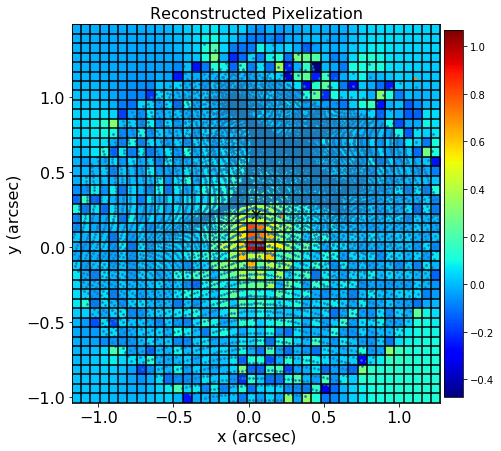

In [28]:
# Now, lets fit this image using the input model and perform the source reconstruction without a border. As you can see,
# we get many demagnified image pixels which trace well beyond our source-plane border if we don't relocate them!
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular,
                                                          use_border=False)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True,
                                                   should_plot_border=True)

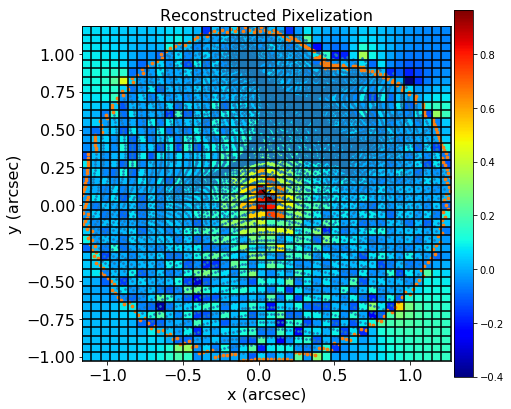

In [30]:
# However, when we relocate them, we get a good-looking source-plane with a well defined border and edge, thus ensuring
# our analysis will (hopefully) be free of systematic biases.
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular,
                                                          use_border=True)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True, 
                                                   should_plot_border=True)

# Multi-galaxy modeling is rife for border effects, and if you have multiple lens galaxies I heartily recommend you
# pay a close eye to your source-plane borders!

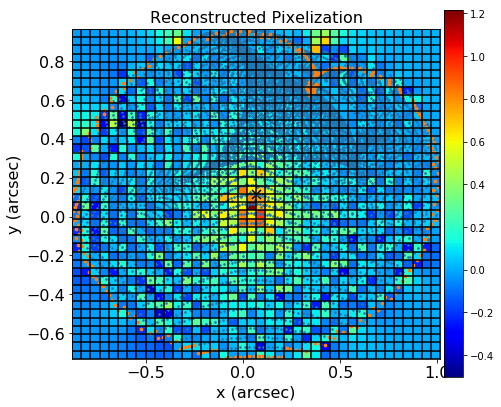

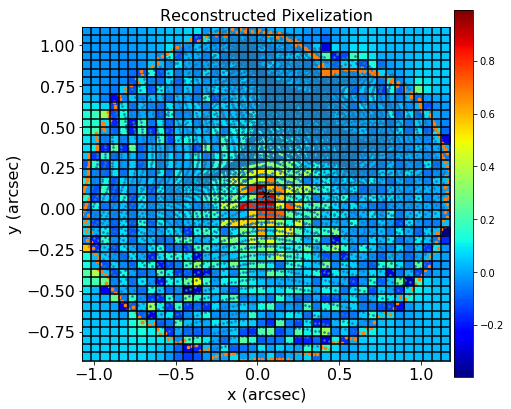

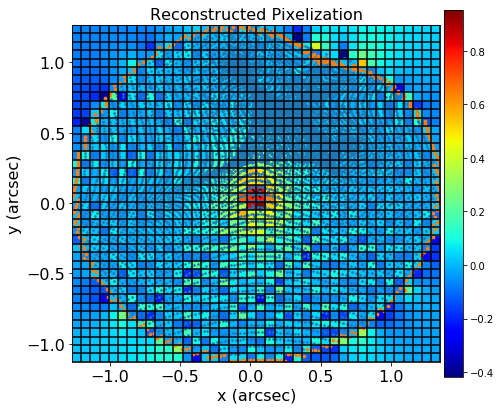

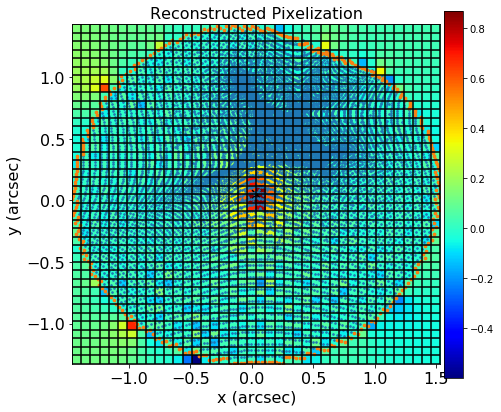

In [31]:
# Before we end,I want to quickly highlight that care must be taken when choosing the size of your mask. If you don't
# choose a big enough mask, the border won't be able to relocate all of the demanigified image pixels to the border
# edge.
mask_circular = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=2.5)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular,
                                                          use_border=True)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True,
                                                   should_plot_border=True)

mask_circular = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=2.7)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular,
                                                          use_border=True)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True,
                                                   should_plot_border=True)

mask_circular = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=2.9)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular,
                                                          use_border=True)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True,
                                                   should_plot_border=True)

mask_circular = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=3.1)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(source_galaxy=source_galaxy, mask=mask_circular,
                                                          use_border=True)
inversion_plotters.plot_reconstructed_pixelization(inversion=fit.inversion, should_plot_grid=True,
                                                   should_plot_border=True)

In [ ]:
# And with that, borders are done. In truth, borders should pretty much take care of themselves when you're
# using PyAutoLens and you probably won't think about them much. However, as I showed above, if you don't choose a
# large enough mask things can go wrong - thus, its important you know what borders are, so you can look out for this
# potential source of systematics!